# Conversion rate challenge

For the sake of completeness, we will implement all the classification methods seen in the course, even those which seem less relevant.

Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Preliminary EDA](#eda)
3. [Logistic regression](#linear)
    A. A first model
    B. Improving the simple model
    C. Further improvements
4. [Decision trees and random forests](#trees)
    A. Decision trees
    B. Random forests
5. [Prototype methods](#prototype)
    A. Linear discriminant analysis (LDA)
6. [Kernel methods](#kernels)
    A. Support vector machines (SVM)
    B. Gaussian processes
7. [Neural networks](#nn)
    A. The simple perceptron
8. [Conclusion and perspectives](#conclusion)

In [1]:
import sys
import time
import warnings

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## <a name="loading"></a>Data loading and preprocessing

A few remarks on this dataset are in order before proceeding:
- Although gathering data about `'country'`, `'source'`, `'total_pages_visited'` would be easy by monitoring server activity, this is not the case for the `'age'`. This is a hint that the dataset is somewhat artificial.
- Before being a recurring user, a user should have been a `'new_user'` at some point. This raises the question of whether a given user could have been included multiple times in the dataset until they subscribe (or not) to the newsletter.
- Only 4 countries are considered here, which is unlikely for a website. 

In the analysis provided next, we ignore all these issues and assume the dataset honest, without any user selection bias.

In [2]:
df = pd.read_csv('./conversion_data_train.csv')
df

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0
...,...,...,...,...,...,...
284575,US,36,1,Ads,1,0
284576,US,31,1,Seo,2,0
284577,US,41,1,Seo,5,0
284578,US,31,1,Direct,4,0


In [3]:
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


There are 284 520 observations, with no missing data. Most feature observations are consistent with what could be expected, except for the `'age'` which has a maximal value of 123. This is larger than the age of the oldest person ever verified. Let us explore if we have other outliers.

In [4]:
df.loc[df['age'] > 70]

,country,age,new_user,source,total_pages_visited,converted
11331,UK,111,0,Ads,10,1
104541,US,72,1,Direct,4,0
175251,US,73,1,Seo,5,0
230590,US,79,1,Direct,1,0
233196,Germany,123,0,Seo,15,1
268311,US,77,0,Direct,4,0


There is a 32-year age gap between 79 and 111, with 2 website visitors older than 80 years old. We choose to remove those 2 records from the dataset.

In [5]:
df = df.loc[df['age'] < 80]
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284578,284578.000000,284578.000000,284578,284578.000000,284578.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139476,NaN,NaN
mean,NaN,30.563596,0.685457,NaN,4.873198,0.032251
std,NaN,8.263627,0.464334,NaN,3.341939,0.176667
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


## <a name="eda"></a>Preliminary EDA

Let us begin with a preliminary semi-quantitative analysis. We aim to predict the subscription to the website newsletter, the first thing to do is to look at the incidence of each feature on the subscription probability. We will then move forward by evaluating some cross effects.

In [6]:
def prob_distrib(df: pd.DataFrame,
                 group_by: str,
                 variables: list[str],
                 xvals: list[np.ndarray],
                 ) -> tuple[list, np.ndarray, np.ndarray, np.ndarray]:
    """
    For each element in the `group_by` column, compute the conversion
    probability and a std deviation estimate as a function of the values in the
    columns in `variables`.
    xvals[i] contains an array of values taken by df[variables[i]].
    
    Returns
    -------
    group_vals : list
        The different elements in the `group_by` column of the dataframe.
    counts : np.ndarray of shape (ngroups,) + (len(x) for x in xvals)
        counts[k, i0, .., in] is the number of rows in the k-th group dataframe
        with variables values xvals[0][i0], ..., xvals[n][in]
    pconv : np.ndarray, same shape as `counts`
        The conversion probability (mean of column 'converted'). The value is
        NaN when the corresponding counts are zero.
    std_pconv : np.ndarray, same shape as `pconv`
        An estimate of the std deviation of pconv: p(1-p)/sqrt(n).

    """
    group_vals = []
    counts = np.zeros((df[group_by].nunique(),) + tuple(len(x) for x in xvals),
                      dtype=int)
    pconv = np.full((df[group_by].nunique(),) + tuple(len(x) for x in xvals),
                    np.nan, dtype=float)

    indices = [{x: i for i, x in enumerate(xs)} for xs in xvals] # manage the case of non-integer indices
    for k, (group, gdf) in enumerate(df.groupby(group_by)):
        group_vals.append(group)
        for idx, c in gdf.loc[:, variables].value_counts().items():
            idx = tuple(indice[i] for indice, i in zip(indices, idx))
            counts[k, *idx] = c
        pconv_df = gdf.loc[:, variables + ['converted']] \
                      .groupby(variables) \
                      .mean()['converted']
        for idx, p in pconv_df.items():
            idx = idx if isinstance(idx, tuple) else (idx,)  # cast to tuple if no multiindex
            idx = tuple(indice[i] for indice, i in zip(indices, idx))
            pconv[k, *idx] = p

    std_pconv = np.where(pconv * (1 - pconv) == 0., 1, pconv) / np.sqrt(counts)
    return group_vals, counts, pconv, std_pconv


def prob_distrib_plot(xvals: np.ndarray,
                      counts: np.ndarray,
                      pconv: np.ndarray,
                      std_pconv: np.ndarray,
                      group_labels: list[str]):
    """
    Make two plots:
    Left: using `counts`, plot the probablity density of the selected variable
          for each group.
    Right: using `pconv` and `std_pconv`, plot the conversion probability vs
           selected variable for each group.

    Parameters
    ----------
    xvals : 1D np.ndarray
        The values taken by the selected variable.
    counts, pconv, std_pconv : 2D np.ndarray, shape (ngroups, len(xvals))
        arr[i, j] = relevant quantity for group i, at xvals[j].
    group_labels : list[str]
        The group labels.

    Returns
    -------
    fig , axs: matplotlib Figure, np.ndarray[matplotlib Axes], shape (2,)
        The figure and axes, for further processing.

    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

    axs[0].grid(visible=True)
    distribs = counts / np.sum(counts, axis=1, keepdims=True)
    for k, label in enumerate(group_labels):
        axs[0].plot(xvals, distribs[k], color=f'C{k}',
                    linewidth=1, label=f'{label} ({int(np.sum(counts[k]))})')
    axs[0].set_xlim(0, np.max(xvals)+1)
    axs[0].set_ylim(-np.max(distribs)*0.02, np.max(distribs)*1.02)
    axs[0].set_ylabel('Prob. density')

    axs[1].grid(visible=True)
    for k, label in enumerate(group_labels):
        axs[1].errorbar(xvals, pconv[k], yerr=std_pconv[k],
                        color=f'C{k}', fmt='o', markersize=3, markeredgewidth=0.3,
                        label=label)
    axs[1].set_xlim(0, np.max(xvals)+1)
    axs[1].set_ylim(-0.005, int(np.max(pconv[~np.isnan(pconv)])*120)/100)
    axs[1].set_title("Conversion probability")
    axs[1].set_ylabel('Conversion probability')

    return fig, axs

In [7]:
df.groupby(['country', 'converted']).count()['age'] # the name 'age' is irrelevant here

country  converted
China    0             69033
         1                89
Germany  0             10963
         1               729
UK       0             41350
         1              2290
US       0            154054
         1              6070
Name: age, dtype: int64

In [8]:
df.groupby(['source', 'converted']).count()['age']

source  converted
Ads     0             77242
        1              2784
Direct  0             63266
        1              1810
Seo     0            134892
        1              4584
Name: age, dtype: int64

#### Categorical variables heatmaps

To get more precise insights, let's make heatmaps.

In [9]:
sources = ['Ads', 'Direct', 'Seo']
countries = ['China', 'Germany', 'UK', 'US']
new_user, counts, pconv, _ = prob_distrib(
    df, group_by='new_user', variables=['source', 'country'],
    xvals=[sources, countries])

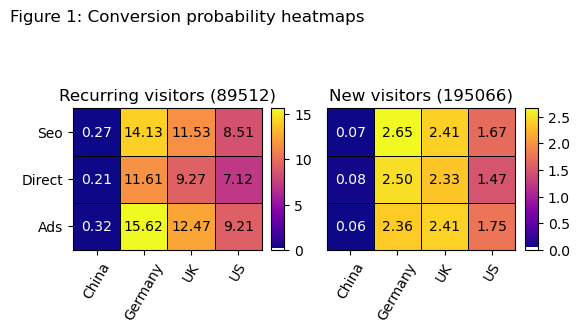

In [10]:
fig1, axs1 = plt.subplots(nrows=1, ncols=2, figsize=(6, 3.5))
fig1.suptitle('Figure 1: Conversion probability heatmaps', x=0.02, ha='left')

axs1_cb = np.empty_like(axs1, dtype=object)
for k, ax in enumerate(axs1):
    ax.set_aspect('equal')
    heatmap = ax.pcolormesh(100*pconv[k], cmap='plasma', edgecolors='k', lw=0.5)
    ax.set_xticks([0.5, 1.5, 2.5, 3.5], countries, rotation=60)
    ax.set_yticks([0.5, 1.5, 2.5], sources)
    for (i, j), p in np.ndenumerate(pconv[k]):
        color = 'k' if p > np.max(pconv[k]) / 3 else 'w'
        ax.text(j+0.5, i+0.5, f'{100*p:.2f}', color=color, ha='center', va='center')
    
    div = make_axes_locatable(ax)
    axs1_cb[k] = div.append_axes("right", size="7%", pad="5%")
    fig1.add_axes(axs1_cb[k])
    fig1.colorbar(heatmap, cax=axs1_cb[k], orientation="vertical", ticklocation="right")


axs1[0].set_title(f"Recurring visitors ({np.sum(counts[0])})")
axs1_cb[0].set_yticks([0, 5, 10, 15])

axs1[1].set_title(f"New visitors ({np.sum(counts[1])})")
axs1[1].tick_params(left=False, labelleft=False)
axs1_cb[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5])

plt.show()

Here we show heatmaps of the newsletter subscription probabilility for the categorical features `'source'` and `'country'`, for both new user and recurring users. We can make the following remarks:
- Recurring visitors are 2.5 - 8 times more likely to subscribe to the newsletter.
- Chinese visitors are much less likely to subscribe than others, and US visitors tend to subscribe less than europeans.
- The way by which visitors reached the website has little impact on their eventual subscription.

#### Influence of visitor's age



In [11]:
ages = np.arange(80)
new_user, age_counts, age_pconv, age_std_pconv = prob_distrib(
    df, group_by='new_user', variables=['age'], xvals=[ages])

In [12]:
def decay_exp(x: np.ndarray,
              A: float,
              tau: float) -> np.ndarray:
    """
    Exponential decay: f(x) = A * exp(- x / tau)
    """
    return A * np.exp(- x / tau)


idx = ~np.isnan(age_pconv)
popt, pcov = [], []
for k, i in enumerate(idx):
    popt_, pcov_ = curve_fit(decay_exp, ages[i], age_pconv[k, i], p0=(0.1, 10),
                             sigma=age_std_pconv[k, i])
    popt.append(popt_)
    pcov.append(pcov_)

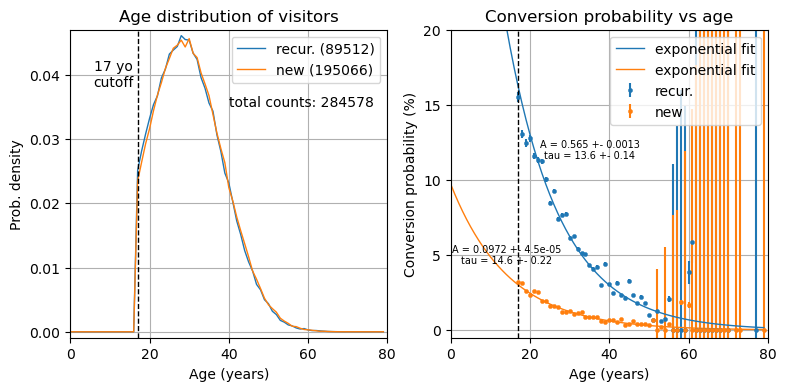

In [13]:
fig2, axs2 = prob_distrib_plot(
    ages, age_counts, age_pconv, age_std_pconv,
    group_labels=['recur.', 'new'])
fig2.suptitle("Figure 2: Influence of 'age'", x=0.02, ha='left')

axs2[0].text(40, 0.035, f'total counts: {int(np.sum(age_counts))}')
axs2[0].axvline(17, color='k', linewidth=1, linestyle='--')
axs2[0].text(11, 0.04, '17 yo\ncutoff', ha='center', va='center')
axs2[0].set_title("Age distribution of visitors")
axs2[0].set_xlabel('Age (years)')
axs2[0].legend(loc=1)

for k, popt_ in enumerate(popt):
    axs2[1].plot(ages, decay_exp(ages, *popt_),
                 linewidth=1, color=f'C{k}', label='exponential fit')
popt_txt = [f'A = {popt_[0]:.3} +- {pcov_[0, 0]:.2}\ntau = {popt_[1]:.3} +- {pcov_[1, 1]:.2}'
            for popt_, pcov_ in zip(popt, pcov)]
axs2[1].text(35, 0.12, popt_txt[0], ha='center', va='center', fontsize=7)
axs2[1].text(14, 0.05, popt_txt[1], ha='center', va='center', fontsize=7)
axs2[1].axvline(17, color='k', linewidth=1, linestyle='--')
axs2[1].set_yticks([0, 0.05, 0.1, 0.15, 0.2], [0, 5, 10, 15, 20])
axs2[1].set_ylabel('Conversion probability (%)')
axs2[1].set_title("Conversion probability vs age")
axs2[1].set_xlabel('Age (years)')
axs2[1].legend()

plt.show()

Here we show the distribution of ages (left panel) and the conversion probability (right panel)
aggregated by `'source'` and `'country'`, but distinguishing new and recurrent visitors.
- The distribution of ages is the same for the two categories: a truncated gaussian with a cutoff at 17 years old,
  centered at around 28 years old. The probability of having a new visitor is roughly twice that of a recurrent visitor.
- The newsletter subscription probability decays with age. The observed decay fits well with an exponential
  from which we recover very similar decay constants of about 14 years. The multiplicative factor is 5-6 times higher
  for recurrent visitors than for new visitors, and so is the subscription probability both both categories, *independently of age*.

These patterns are extremely regular and again reveal the artificial nature of the data. They would certainly not be occur in a realistic context.

#### Influence of the number of pages visited

We proceed in a similar fashion this time with the quantity `'total_pages_visited'`.

In [14]:
npages = np.arange(30)
new_user, npage_counts, npage_pconv, npage_std_pconv = prob_distrib(
    df, group_by='new_user', variables=['total_pages_visited'], xvals=[npages])

In [15]:
def sigmoid(x: np.ndarray,
            x0: float,
            a: float) -> np.ndarray:
    """
    Exponential decay: f(x) = 1 / (1 + exp(- a * (x - x0)))
    """
    return 1 / (1 + np.exp(- a * (x - x0)))

idx = ~np.isnan(npage_pconv)
popt, pcov = [], []
for k, i in enumerate(idx):
    popt_, pcov_ = curve_fit(sigmoid, npages[i], npage_pconv[k, i], p0=(15, 1))
    popt.append(popt_)
    pcov.append(pcov_)

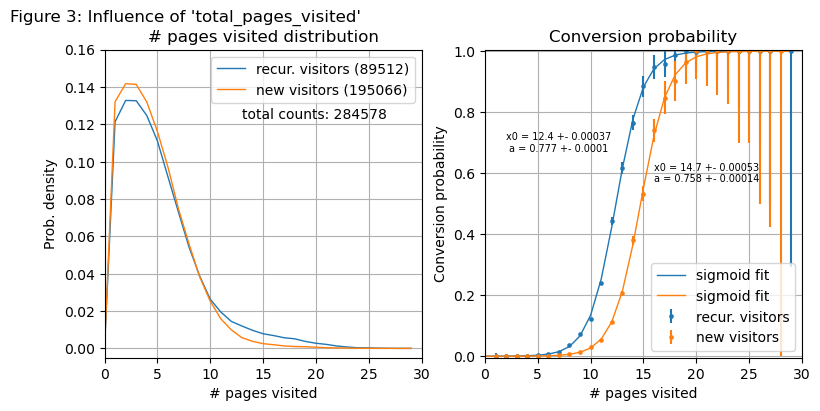

In [16]:
fig3, axs3 = prob_distrib_plot(
    npages, npage_counts, npage_pconv, npage_std_pconv,
    group_labels=['recur. visitors', 'new visitors'])
fig3.suptitle("Figure 3: Influence of 'total_pages_visited'", x=0.02, ha='left')

axs3[0].text(13, 0.123, f'total counts: {int(np.sum(npage_counts))}')
axs3[0].set_ylim(-0.005, 0.16)
axs3[0].set_title("# pages visited distribution")
axs3[0].set_xlabel('# pages visited')
axs3[0].legend()


for k, popt_ in enumerate(popt):
    axs3[1].plot(npages, sigmoid(npages, *popt_),
                 linewidth=1, color=f'C{k}', label='sigmoid fit')

popt_txt = [f'x0 = {popt_[0]:.3} +- {pcov_[0, 0]:.2}\na = {popt_[1]:.3} +- {pcov_[1, 1]:.2}'
            for popt_, pcov_ in zip(popt, pcov)]
axs3[1].text(7, 0.7, popt_txt[0], ha='center', va='center', fontsize=7)
axs3[1].text(21, 0.6, popt_txt[1], ha='center', va='center', fontsize=7)

axs3[1].set_xlim(0, 30)
axs3[1].set_ylim(-0.005, 1.005)
# axs3[1].set_yticks([0, 0.05, 0.1, 0.15, 0.2], [0, 5, 10, 15, 20])
# axs3[1].set_yticks([0, 0.05, 0.1, 0.15, 0.2], minor=True)
axs3[1].set_title("Conversion probability")
axs3[1].set_xlabel('# pages visited')
axs3[1].set_ylabel('Conversion probability')
axs3[1].legend()

plt.show()

Here we show the distribution of number of pages visited (left panel) and the corresponding conversion probability (right panel) built the same way as in the previous figure.
- Although we still have a factor ~2 between the total counts, we remark that website visits with more than 13 pages visited are mostly done by recurrent visitors. Accounting for the factor 2, this makes it more than twice likely that a > 13 pages visit is done by a recurrent visitor.
- The two distributions are thus not proportional. They actually look like [inverse-gamma distributions](https://en.wikipedia.org/wiki/Inverse-gamma_distribution).
- The newsletter subscription probability looks like a sigmoid for both new and recurring visitors. The inflection points are shifted, and looking at the 13 pages-visits threshold, we see that here the conversion probability is thrice for recurring users than for new users.
- Sigmoid fits with the slope and inflection point as parameters is also shown on the right panel. The slopes are roughly the same, the difference being the inflection point: 12.5 pages for recurring visitors vs 15 pages for new visitors.
- Finally, we note two outlier events on the right panel. ~30 pages visits with no subscription. We might consider removing these observations for training later on.

We again stress that such regularity is unlikely in any realistic context.

#### Combined influence of country and number of pages visited

We noted above that the country of origin has a significant impact on the conversion probability.
We consider the two following hypotheses to explain this trend:
- The country of orgin has an impact on the distribution of number of pages visited, but not on the subscription threshold (the inflection point of the sigmoid).
  In this case, the country is expected to not be a good a predictor: the relevant information would be already contained in the number of pages visited.
- The pages visits distribution does not depend on the country, but the conversion threshold does. In this case, the country (more precisely, its correlation with the number of pages visted)
  would be a highly relevant predictor.
For comparison, the new/recurring character of visitors effect is a mixture of these two: it affects both the pages visits distribution and conversion threshold.

In [17]:
npages = np.arange(30)
country, npage_counts, npage_pconv, npage_std_pconv = prob_distrib(
    df, group_by='country', variables=['total_pages_visited'], xvals=[npages])

In [18]:
idx = ~np.isnan(npage_pconv)
popt, pcov = [], []
for k, i in enumerate(idx):
    popt_, pcov_ = curve_fit(sigmoid, npages[i], npage_pconv[k, i], p0=(15, 1))
    popt.append(popt_)
    pcov.append(pcov_)

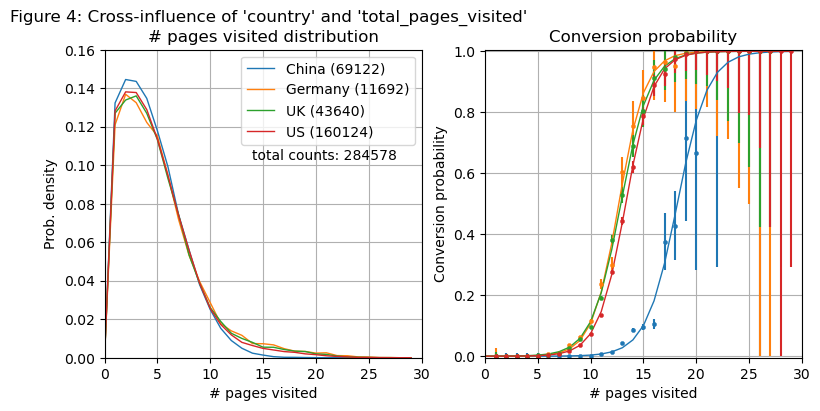

In [19]:
fig4, axs4 = prob_distrib_plot(
    npages, npage_counts, npage_pconv, npage_std_pconv,
    group_labels=country)
fig4.suptitle("Figure 4: Cross-influence of 'country' and 'total_pages_visited'", x=0.02, ha='left')

axs4[0].text(14, 0.103, f'total counts: {int(np.sum(npage_counts))}')
axs4[0].set_ylim(0, 0.16)
axs4[0].set_title("# pages visited distribution")
axs4[0].set_xlabel('# pages visited')
axs4[0].legend(loc=1)

for k, popt_ in enumerate(popt):
    axs4[1].plot(npages, sigmoid(npages, *popt_),
                 linewidth=1, color=f'C{k}', label='sigmoid fit')
axs4[1].set_ylim(-0.005, 1.005)
axs4[1].set_xlabel('# pages visited')
# axs4[1].legend()

plt.show()

Here we show, for each country, the distribution of pages visited (left panel) and the conversion probability as a function of the number of pages visited (right panel).
- The behavior of users from `'Germany'`, `'UK'` and `'US'` is quite similar both in terms of page visits and conversion probability thresholding with a tendency Germany < UK < US
which matches the differences observed in figure 1.
- The behavior difference of users from `'China'` is striking. First, the distibution of pages visits is different, with much less visits of more than 13 pages, those which are associated to newsletter subscription.
Second, the threshold seems to be set at a significantly higher level than other countries. These two factors explain the much lower conversion rates observed in figure 1.

#### Combined influence of source and number of pages visited

In [20]:
npages = np.arange(30)
source, npage_counts, npage_pconv, npage_std_pconv = prob_distrib(
    df, group_by='source', variables=['total_pages_visited'], xvals=[npages])

In [21]:
idx = ~np.isnan(npage_pconv)
popt, pcov = [], []
for k, i in enumerate(idx):
    popt_, pcov_ = curve_fit(sigmoid, npages[i], npage_pconv[k, i], p0=(15, 1))
    popt.append(popt_)
    pcov.append(pcov_)

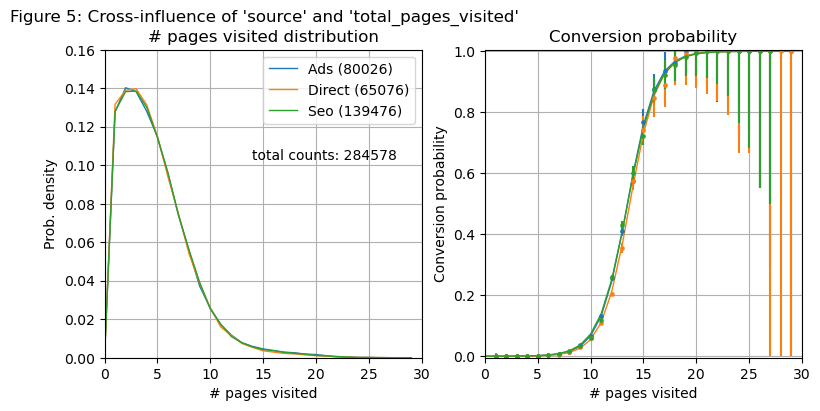

In [22]:
fig5, axs5 = prob_distrib_plot(
    npages, npage_counts, npage_pconv, npage_std_pconv,
    group_labels=source)
fig5.suptitle("Figure 5: Cross-influence of 'source' and 'total_pages_visited'", x=0.02, ha='left')

axs5[0].text(14, 0.103, f'total counts: {int(np.sum(npage_counts))}')
axs5[0].set_ylim(0, 0.16)
axs5[0].set_title("# pages visited distribution")
axs5[0].set_xlabel('# pages visited')
axs5[0].legend(loc=1)

for k, popt_ in enumerate(popt):
    axs5[1].plot(npages, sigmoid(npages, *popt_),
                 linewidth=1, color=f'C{k}', label='sigmoid fit')
axs5[1].set_ylim(-0.005, 1.005)
axs5[1].set_xlabel('# pages visited')
# axs5[1].legend()

plt.show()

The plot shows...

#### Combined influence of age and number of pages visited

In [23]:
new_user, npages = np.arange(80), np.arange(30)
country, counts, pconv, std_pconv = prob_distrib(
    df, group_by='new_user', variables=['age', 'total_pages_visited'],
    xvals=[ages, npages])

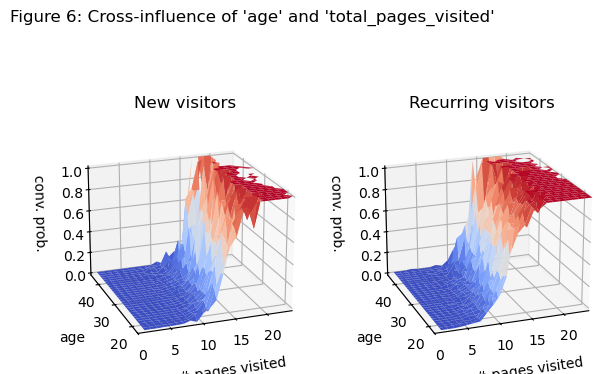

In [24]:
x, y = np.meshgrid(npages[:25], ages[17:46])

fig6, axs6 = plt.subplots(
    nrows=1, ncols=2,
    gridspec_kw={'left': 0.1, 'right': 0.95, 'top': 0.9, 'bottom': 0.1},
    subplot_kw=dict(projection='3d'))
fig6.suptitle("Figure 6: Cross-influence of 'age' and 'total_pages_visited'", x=0.02, ha='left')

# new visitors
axs6[0].view_init(elev=20, azim=-110)
surf = axs6[0].plot_surface(
    x, y, pconv[1, 17:46, :25], rstride=1, cstride=1, cmap='coolwarm',
    linewidth=0, antialiased=True, shade=False)

axs6[0].set_xlim(0, 24)
axs6[0].set_ylim(17, 45)
axs6[0].tick_params(pad=0)
axs6[0].set_title('New visitors')
axs6[0].set_xlabel('# pages visited')
axs6[0].set_ylabel('age')
axs6[0].set_zlabel('conv. prob.')

# recurring visitors
axs6[1].view_init(elev=20, azim=-110)
surf = axs6[1].plot_surface(
    x, y, pconv[0, 17:46, :25], rstride=1, cstride=1, cmap='coolwarm',
    linewidth=0, antialiased=True, shade=False)

axs6[1].set_xlim(0, 24)
axs6[1].set_ylim(17, 45)
axs6[1].tick_params(pad=0)
axs6[1].set_title('Recurring visitors')
axs6[1].set_xlabel('# pages visited')
axs6[1].set_ylabel('age')
axs6[1].set_zlabel('conv. prob.')

plt.show()

The figure shows the conversion probability as a function of age and number of pages visited
for both new (left panel) and recurring (right panel) visitors.
- the sigmoid dependence of the conversion probability vs. number of pages visited is valid over the whole age range.
- In both conditions, there is a small linear dependence of the inflection point with age, with a lower inflection point for younger visitors.

#### Summary

In summary, we gathered the following insights about the dependence of the subscription probability with various features:
- The behavior of website visitors from `'China'` differs significantly with that of users from other countries. A predictive model could completely distinguish the two populations, that is we could make one model trained on data from chinese users and one model with the rest of the data.
- The behavior of website visitors depends significantly on the country and on whether they visit for the first time, but less so of how they reached the website. We could consider building new features $\mathrm{country} \times X$, $\mathrm{new\_ user} \times X$, and even $\mathrm{country} \times \mathrm{new\_ user} \times X$, where $X$ represents any other feature.
- There is an exponential dependence of the subscription probability in the visitors' age, $p_{\mathrm{conv}} \propto \exp(-\mathrm{age} / 14)$. We could consider adding this quantity to the features. However, the exponential looks linear enough on the range explored and this might not be useful.
- The subscription probability has a sigmoid dependence in the number of pages visited. The latter feature is thus clearly the most relevant in predicting the newsletter subscription.
- The last plot showed the inflection point of this sigmoid relationship to be slightly dependent on the age of the visitor. We could thus add the feature product $\mathrm{age} \times \mathrm{total\_ pages\_ visited}$ to the model.

## <a name="linear"></a>Logistic regression

In [25]:
from hashlib import shake_256
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (f1_score,
                             confusion_matrix,
                             roc_curve,
                             auc)
from sklearn.svm import LinearSVC
from sklearn.linear_model import (LogisticRegression, SGDClassifier)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   FunctionTransformer,
                                   PolynomialFeatures)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     cross_validate,
                                     StratifiedKFold,
                                     TunedThresholdClassifierCV)
from sklearn.base import clone
from scipy.optimize import curve_fit
warnings.simplefilter("ignore", ConvergenceWarning)


def evaluate_model(pipeline: Pipeline,
                   export_csv: bool = False,
                   name_suffix: str = 'EXAMPLE') -> np.ndarray:
    """
    Evaluate the model on the test set. The predictions are exported as
    'conversion_data_test_predictions_{name_suffix}.csv'

    Parameters
    ----------
    Pipeline : Callable: pd.DataFrame -> T
        The feature preprocessor.
    export_csv : bool, optional
        Export the test data as a csv file for challenge assessment.
        The default is False.
    name_suffix : str, optional
        Suffix appended to the output filename. The default is 'EXAMPLE'.

    Returns
    -------
    Y_pred : 1D np.ndarray
        The model's predictions on the test set.
    """
    df = pd.read_csv('./conversion_data_test.csv')
    Y_pred = pipeline.predict(df)

    if export_csv:
        fname = f'conversion_data_test_predictions_{name_suffix}.csv'
        np.savetxt(fname, Y_pred, fmt='%d', header='converted', comments='')

    return Y_pred

### A first model

We reproduce here the basic linear regression from the template, this time including all the features in the fit.
We do a simple train-test split using the train set, without relying on the test set provided due to limited access.


In [26]:
# Data to fit
y = df.loc[:, 'converted']
X_df = df.drop('converted', axis=1)

# One-hot encoding with pandas
X_df = pd.get_dummies(X_df)
X = X_df.drop(['country_US', 'source_Seo'], axis=1)

# Simple train-test split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Data scaling: scale everything, including categorical data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)

# fit logistic regression classifier
model1 = LogisticRegression()
model1.fit(X_tr, y_tr)

LogisticRegression()

In [27]:
# train set predicitions
y_tr_pred = model1.predict(X_tr)

# test set predicitions
X_test = scaler.transform(X_test)  # no fit this time
y_test_pred = model1.predict(X_test)

# metrics
print(f'Train set F1-score: {f1_score(y_tr, y_tr_pred)}')
print("Train set confusion matrix\n",
      confusion_matrix(y_tr, y_tr_pred, normalize='all'))
print(f'Test set F1-score: {f1_score(y_test, y_test_pred)}')
print("Test set confusion matrix\n",
      confusion_matrix(y_test, y_test_pred, normalize='all'))

Train set F1-score: 0.7635583562378494
Train set confusion matrix
 [[0.96399344 0.00375605]
 [0.01001484 0.02223567]]
Test set F1-score: 0.7618469015795869
Test set confusion matrix
 [[0.96419285 0.00354909]
 [0.0102256  0.02203247]]


### Improving the simple model

Let us now make some improvements to the previous code, without changing the model (almost).

A first improvement is to make it work in a more integrated fashion. We thus do the following:
- The data preprocessing, encoding of categorical variables and scaling of quantitative variables, is wrapped in a `compose.ColumnTransformer`
- The preprocessing and classification are wrapped in a `pipeline.Pipeline`, exposing a single interface for all steps

Note that one-hot encoding can be done with pandas
```python
X = pd.get_dummies(X).drop(['country_US', 'source_Seo'], axis=1)

In [28]:
# data preparation
y = df.loc[:, 'converted']
X = df.drop('converted', axis=1)

# preprocessing
cat_vars = ['country', 'source']
bool_vars = ['new_user']
quant_vars = ['age', 'total_pages_visited']
col_preproc = ColumnTransformer(
    [('cat_ohe', OneHotEncoder(drop='first'), cat_vars),
     ('bool_id', FunctionTransformer(None), bool_vars),
     ('quant_scaler', StandardScaler(), quant_vars)])

# full pipeline
pipeline = Pipeline([('column_preprocessing', col_preproc),
                     ('classifier', LogisticRegression())])

The default logistic regression classifier uses a threshold probability of 0.5 to classify an observation.
This corresponds to the minimization of the logistic loss.
However, we recall that the performance of our model is assessed not by the average logistic loss but through the F1-score.
Our model can adjust by cross-validation this threshold probability so as to maximize the F1-score. This is done by wrapping the
pipeline into a `model_selection.TunedThresholdClassifierCV`.

In [29]:
model1_ta = TunedThresholdClassifierCV(pipeline, scoring='f1', cv=10,
                                       random_state=1234,
                                       store_cv_results=True)
t0 = time.time()
model1_ta.fit(X, y)
t1 = time.time()
print(f'model fitting time: {t1-t0} s')

best_thr = model1_ta.best_threshold_
best_score = model1_ta.best_score_

print(f'best threshold = {best_thr:.8f}',
      f'\nbest F1-score = {best_score:.8f}')

model fitting time: 23.899059057235718 s
best threshold = 0.39393816 
best F1-score = 0.77059657


#### metrics: confusion matrix and ROC

The receiver operating characteristic (ROC) curve is the natural metric associated to the classification threshold variation.
We produce the mean curve through 10-times cross validation building a ROC curve from each validation set and averaging the results.

We also use the data to compute the mean confusion matrix at the threshold selected above. Compared to that of the non-adjusted linear regression,
we get 15% less false negatives, at the expense of 50% more false positives. However,

 since the latter are not involved in the computation of the F1 score,
the overall result is an improved value.

In [30]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
clf = Pipeline([('column_preprocessing', col_preproc),
                ('classifier', LogisticRegression())])

mean_cm = np.zeros((2, 2), dtype=float)  # confusion matrix
mean_fpr = np.linspace(0, 1, 101)  # false-positive rates
mean_tpr = np.zeros(101, dtype=float)  # true-positive rates
thr_fpr, thr_tpr = 0, 0  # fpr, tpr at threshold
for i, (itr, ival) in enumerate(cv.split(X, y)):
    X_v, y_v = X.iloc[ival], y.iloc[ival]
    clf.fit(X.iloc[itr], y.iloc[itr])
    # confusion matrix
    y_pred = clf.predict_proba(X_v)[:, 1] > best_thr
    mean_cm += confusion_matrix(y_v, y_pred) / len(X)
    # ROC
    y_decision = clf.decision_function(X_v)
    fpr, tpr, thr = roc_curve(y_v, y_decision)
    mean_tpr += np.interp(mean_fpr, fpr, tpr, left=0, right=1) / n_splits
    thr_fpr += np.interp(best_thr, expit(thr[::-1]), fpr[::-1]) / n_splits
    thr_tpr += np.interp(best_thr, expit(thr[::-1]), tpr[::-1]) / n_splits
mean_tpr[0] = 0
mean_auc = auc(mean_fpr, mean_tpr)

# print("Mean confusion matrix\n", mean_cm)
recall = mean_cm[1, 1] / np.sum(mean_cm, axis=1)[1]
prec = mean_cm[1, 1] / np.sum(mean_cm, axis=0)[1]
print("CV-estimated confusion matrix\n", mean_cm / np.sum(mean_cm))
print(f'CV-estimated precision: {prec:.8}; recall: {recall:.8}')
print(f'CV-estimated F1-score = {2*prec*recall/(prec+recall):.8}')

CV-estimated confusion matrix
 [[0.96203501 0.00571372]
 [0.00847219 0.02377907]]
CV-estimated precision: 0.80626713; recall: 0.7373066
CV-estimated F1-score = 0.77024643


We plot the ROC curve in figure 7. The location of our selected threshold is indicated on the curve as an orange cross.

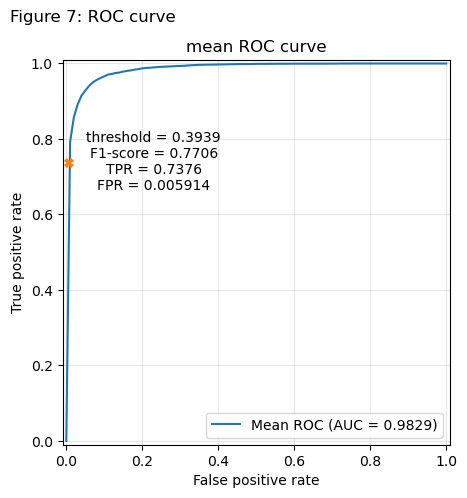

In [31]:
fig7, ax7 = plt.subplots(figsize=(5, 5))
fig7.suptitle('Figure 7: ROC curve', x=0.02, ha='left')

ax7.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.4f})')
ax7.plot(thr_fpr, thr_tpr, marker='X', markersize=7, markeredgewidth=0.1)

ax7.legend(loc=4)
ax7.set_title('mean ROC curve')
ax7.set_xlabel('False positive rate')
ax7.set_ylabel('True positive rate')
ax7.set_xlim(-0.01, 1.01)
ax7.set_ylim(-0.01, 1.01)
ax7.grid(visible=True, alpha=0.3)

thr_txt = (f'threshold = {best_thr:.4f}\nF1-score = {best_score:.4f}\n'
           f'TPR = {thr_tpr:.4}\nFPR = {thr_fpr:.4}')
ax7.text(0.23, 0.74, thr_txt, ha='center', va='center')

plt.show()

### Further improvements

#### Model construction

In [32]:
# split the dataset
groups = ['new_user']
Xs = {idx: df_.drop(groups, axis=1) for idx, df_ in X.groupby(groups)}
ys = {idx: y.loc[X_.index] for idx, X_ in Xs.items()}

# column preprocessing
cat_vars_2 = [v for v in cat_vars if v not in groups]
bool_vars_2 = [v for v in bool_vars if v not in groups]
quant_vars_2 = [v for v in quant_vars if v not in groups]
col_preproc = ColumnTransformer(
    [('cat_ohe', OneHotEncoder(drop=None), cat_vars_2),
     ('id_', FunctionTransformer(None), bool_vars_2 + quant_vars_2)])

# custom feature engineering
def poly_features(X: np.ndarray) -> np.ndarray:
    """
    Custom polynomial features construction:
        - Original features, Xi
        - 2nd order polynomials of quantitative features, Xi^2, Xi*Xj
        - Products of categorical and quantitative features, Xi_cat * Xj_quant
    """
    X_ = np.empty((len(X), 26), dtype=float)
    X_[:, :9] = X  # original features
    X_[:, 9:11] = X[:, 7:9]**2  # age**2, npages**2
    X_[:, 11] = X[:, 7] * X[:, 8]  # age * npages
    X_[:, 12:19] = X[:, :7] * X[:, [7]]  # cat * age
    X_[:, 19:26] = X[:, :7] * X[:, [8]]  # cat * npages
    return X_

# classifier: SVM classifier with linear kernel
logreg_clf = LogisticRegression(
    penalty='elasticnet',
    C=0.1,
    fit_intercept=True,  # intercept already included as a feature by `PolynomialFeatures`
    class_weight=None,
    solver='saga',  # supports elasticnet penalty
    random_state=1234,
    l1_ratio=0.8,
)

# full pipeline, including polynomial feature generation
pipeline = Pipeline(
    [('column_preprocessing', col_preproc),
     ('poly_features', FunctionTransformer(poly_features)),
     ('scaler', StandardScaler()),
     ('classifier', logreg_clf)]
)
pipelines = {idx: clone(pipeline) for idx in Xs}

In [34]:
# optional: optimize parameters
"""
for idx, pipeline in pipelines.items():
    gsearch = GridSearchCV(
        pipeline,  param_grid={'classifier__C': np.logspace(-5, 1, 61)},
        scoring='f1', n_jobs=4, refit=False, cv=10, verbose=False)
    gsearch.fit(Xs[idx], ys[idx])
    best_C = gsearch.best_params_['classifier__C']
    print(f'found best C for idx={idx}: {best_C}')
    pipeline['classifier'].C = best_C
"""

"\nfor idx, pipeline in pipelines.items():\n    gsearch = GridSearchCV(\n        pipeline,  param_grid={'classifier__C': np.logspace(-5, 1, 61)},\n        scoring='f1', n_jobs=4, refit=False, cv=10, verbose=False)\n    gsearch.fit(Xs[idx], ys[idx])\n    best_C = gsearch.best_params_['classifier__C']\n    print(f'found best C for idx={idx}: {best_C}')\n    pipeline['classifier'].C = best_C\n"

#### Model evaluation by cross-validation

In [35]:
# evaluate by cross validation
n_splits = 10
cm = np.zeros((2, 2), dtype=float)  # confusion matrix
cms = {}
for idx, pipeline in pipelines.items():
    cms[idx] = np.zeros((2, 2), dtype=float)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    X_, y_ = Xs[idx], ys[idx]
    for i, (itr, ival) in enumerate(cv.split(X_, y_)):
        pipeline.fit(X_.iloc[itr], y_.iloc[itr])
        cms[idx] += confusion_matrix(y_.iloc[ival],
                                     pipeline.predict(X_.iloc[ival]))
        cm += confusion_matrix(y_.iloc[ival], pipeline.predict(X_.iloc[ival]))
print('===== Partial scores =====')
for idx, cm_ in cms.items():
    recall = cm_[1, 1] / np.sum(cm_, axis=1)[1]
    prec = cm_[1, 1] / np.sum(cm_, axis=0)[1]
    print(f'{idx} : precision: {prec:.8}; recall: {recall:.8};',
          f'F1-score = {2*prec*recall/(prec+recall):.8}')
print('===== Global scores =====')
recall = cm[1, 1] / np.sum(cm, axis=1)[1]
prec = cm[1, 1] / np.sum(cm, axis=0)[1]
print("CV-estimated confusion matrix\n", cm / np.sum(cm))
print(f'CV-estimated precision: {prec:.8}; recall: {recall:.8}')
print(f'CV-estimated F1-score = {2*prec*recall/(prec+recall):.8}')

# fit on the whole dataset
model2 = {idx: pipeline.fit(Xs[idx], ys[idx])
          for idx, pipeline in pipelines.items()}

===== Partial scores =====
(0,) : precision: 0.86649829; recall: 0.74615504; F1-score = 0.80183639
(1,) : precision: 0.82109842; recall: 0.55089383; F1-score = 0.65938865
===== Global scores =====
CV-estimated confusion matrix
 [[0.9639923  0.00375644]
 [0.01006754 0.02218372]]
CV-estimated precision: 0.8551883; recall: 0.68784049
CV-estimated F1-score = 0.76243961


Similarly, we can adjust the classification threshold
It would be difficult to recover a global F1-score estimate since the TunedThresholdClassifierCV won't
return the confusion matrix at each CV round.

In [ ]:
model2_ta = {idx: TunedThresholdClassifierCV(clone(p), scoring='f1', cv=10, random_state=1234)
             for idx, p in pipelines.items()}

t0 = time.time()
for idx, model in model2_ta.items():
    model.fit(Xs[idx], ys[idx])
t1 = time.time()
print(f'model2_ta fitting time: {t1-t0} s')

best_thrs = {idx: m.best_threshold_ for idx, m in model2_ta.items()}
best_scores = {idx: m.best_score_ for idx, m in model2_ta.items()}
for idx in best_thrs:
    print(f'{idx} : best threshold = {best_thrs[idx]:.6f};',
          f'best F1-score = {best_scores[idx]:.6f}')

#### Evaluation on test data

Our two models are `dict`s and as such do not have the `Estimator` interface (and most notably the `predict` method).
To perform evaluation, we wrap our model in a class mimicking the sufficient `Estimator` interface for model evaluation on the test data.

In [ ]:
class MimicEstimator():

    def __init__(self, model: dict, groups: list[str]):
        self.groups: list[str] = groups
        self.model: dict = model

    def predict(self, df: pd.DataFrame) -> np.ndarray:
        y_pred = np.empty(len(df), dtype=int)
        Xs = {idx: df_.drop(groups, axis=1)
              for idx, df_ in df.groupby(self.groups)}
        for idx, X in Xs.items():
            y_pred[X.index] = self.model[idx].predict(X)
        return y_pred


